## Experimenting with image augmentations

In [1]:
from utils import test_transforms
from hparams import Hparams
import os
import torchvision
from random import randrange
from matplotlib.pyplot import imshow


hparams = Hparams()

TRAIN_DIR = os.path.join(hparams.data_dir, "classification/train")
transform_stack = list(hparams.transform_stack_PIL)
train_transforms = torchvision.transforms.Compose(transform_stack)
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)


start = -1
num = 5


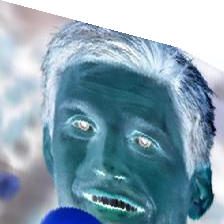

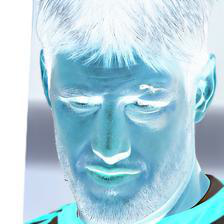

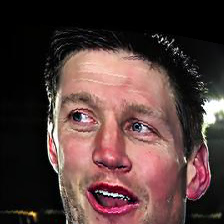

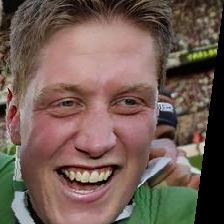

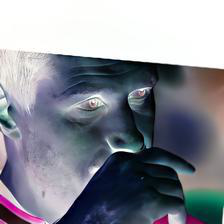

In [2]:
if start == -1:
    offset = randrange(start=0, stop=len(train_dataset) - num)
else:
    offset = start

for i in range(offset, offset + num):
    display(train_dataset[i][0])



## Model Testing

In [3]:
from model import ResNext_BN
from dataproc import build_loaders

import torch
import torch.nn as nn
import torch.nn.functional as F

model = ResNext_BN(hparams)

device = 'cuda'

train, val, test = build_loaders(hparams)

In [4]:
i, (images, labels) = next(iter(enumerate(train)))

In [5]:
out = model(images, headless=True)

In [6]:
class ArcFace(nn.Module):
    """
    Implementation of the ArcFace metric
    """

    def __init__(self, in_feats, out_feats, s=64.0, m=0.5):
        super().__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.s = s
        self.m = m

        self.eps = 1e-7

        # Create weights for the FC layer
        self.W = nn.Parameter(torch.FloatTensor(self.out_feats, self.in_feats))
        nn.init.kaiming_uniform_(self.W)

    def forward(self, x, y):

        theta = F.linear(F.normalize(x), F.normalize(self.W))

        numerator = self.s * torch.cos(
            torch.acos(
                torch.clamp(
                    torch.diagonal(theta.transpose(0, 1)[y]),
                    -1.0 + self.eps,
                    1 - self.eps,
                )
            )
            + self.m
        )

        excl = torch.cat(
            [
                torch.cat((theta[i, :y], theta[i, y + 1 :])).unsqueeze(0)
                for i, y in enumerate(y)
            ],
            dim=0,
        )

        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)

        return -torch.mean(numerator - torch.log(denominator))

af = ArcFace(1024, 7000, device, s=64, m=0.5)

af(out, labels)


AttributeError: 'tuple' object has no attribute 'norm'

In [ ]:
[p for p in af.parameters()]

[Parameter containing:
 tensor([[-0.0736, -0.0008, -0.0577,  ..., -0.0364,  0.0510,  0.0492],
         [ 0.0058, -0.0462, -0.0409,  ...,  0.0749,  0.0620,  0.0475],
         [ 0.0555,  0.0082, -0.0140,  ...,  0.0398,  0.0684, -0.0333],
         ...,
         [-0.0721,  0.0628,  0.0742,  ..., -0.0568,  0.0092,  0.0497],
         [-0.0461, -0.0126, -0.0241,  ...,  0.0183,  0.0038, -0.0065],
         [ 0.0676,  0.0173, -0.0087,  ...,  0.0654,  0.0154, -0.0395]],
        requires_grad=True)]